# Identify toxicity comments

# 1. Description
- A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion. If these toxic contributions can be identified, we could have a safer, more collaborative internet.

- `Disclaimer`: The dataset for this contains text that may be considered profane, vulgar, or offensive.

# 2. Evaluation
- `area under the ROC curve` between the predicted probability and the observed target.

# 3. Data
- `comment_text`: This contains the text of a comment which has been classified as toxic or non-toxic (0...1 in the toxic column). The data set’s comments are entirely in english and come either from Civil Comments or Wikipedia talk page edits.

- What am I predicting?
> We are predicting the probability that a comment is toxic. A toxic comment would receive a 1.0. A benign, non-toxic comment would receive a 0.0. In the test set, all comments are classified as either a 1.0 or a 0.0.

In [1]:
!pip install -q pyicu
!pip install -q pycld2
!pip install -q polyglot
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [2]:
import os
import re
import pandas as pd
import numpy as np
import tqdm
import transformers
import tensorflow as tf

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

from polyglot.detect import Detector

import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)
print(transformers.__version__)
print(tf.keras.__version__)

2.4.1
4.5.1
2.4.0


In [4]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Data Preprocessing

In [5]:
def get_language(text):
    return Detector(
        "".join(x for x in text if x.isprintable()), quiet=True
    ).languages[0].name

PATH =  "jigsaw-multilingual-toxic-comment-classification"
FILES = os.listdir(PATH)
print(FILES)

TRAIN_PATH = os.path.join(PATH, 'jigsaw-toxic-comment-train.csv')
data = pd.read_csv(TRAIN_PATH)

data["lang"] = data["comment_text"].apply(get_language)
data = data[data['lang'] == 'English']

['sample_submission.csv', 'validation-processed-seqlen128.csv', 'test-processed-seqlen128.csv', 'jigsaw-unintended-bias-train-processed-seqlen128.csv', 'validation.csv', 'jigsaw-toxic-comment-train.csv', 'test.csv', 'jigsaw-unintended-bias-train.csv', 'jigsaw-toxic-comment-train-processed-seqlen128.csv']


In [6]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,lang
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,English
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,English
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,English
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,English
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,English


In [7]:
data.toxic.value_counts()

0    199700
1     20953
Name: toxic, dtype: int64

# Split data to Train and Test

In [8]:
X = data[['comment_text']]
y = data[['toxic']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_test = y_test.toxic.values
y_train = y_train.toxic.values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(176522, 1)
(176522,)
(44131, 1)
(44131,)


## Tokenizing the data

In [9]:
def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = transformers.AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

SEQ_LEN = 128
X_train_ids = np.zeros((len(X_train), SEQ_LEN))
X_train_mask = np.zeros((len(X_train), SEQ_LEN))

X_test_ids = np.zeros((len(X_test), SEQ_LEN))
X_test_mask = np.zeros((len(X_test), SEQ_LEN))

for i, sequence in enumerate(X_train['comment_text']):
    tokens = tokenizer.encode_plus(
        sequence, max_length=SEQ_LEN,
        truncation=True, padding='max_length',
        add_special_tokens=True, return_token_type_ids=False,
        return_attention_mask=True, return_tensors='tf'
    )
    X_train_ids[i, :], X_train_mask[i, :] = tokens['input_ids'], tokens['attention_mask']
    
for i, sequence in enumerate(X_test['comment_text']):
    tokens = tokenizer.encode_plus(
        sequence, max_length=SEQ_LEN,
        truncation=True, padding='max_length',
        add_special_tokens=True, return_token_type_ids=False,
        return_attention_mask=True, return_tensors='tf'
    )
    X_test_ids[i, :], X_test_mask[i, :] = tokens['input_ids'], tokens['attention_mask']
    
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_ids, X_train_mask, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_ids, X_test_mask, y_test))

train_dataset = train_dataset.map(map_func)
test_dataset = test_dataset.map(map_func)

train_dataset = train_dataset.shuffle(100000).batch(32, drop_remainder=True)
test_dataset = test_dataset.shuffle(100000).batch(32, drop_remainder=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

# Model Building

In [10]:
bert = transformers.TFAutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

input_ids = tf.keras.layers.Input(shape=(SEQ_LEN, ), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN, ), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_ids, attention_mask=mask)[1]

X = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
# X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
# X = tf.keras.layers.BatchNormalization()(X)
# X = tf.keras.layers.Dense(128, activation='relu')(X)
# X = tf.keras.layers.Dropout(0.1)(X)
# X = tf.keras.layers.Dense(32, activation='relu')(X)
y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6), 
    loss='binary_crossentropy', 
    metrics=[tf.keras.metrics.AUC(name='AUC')]
)

r = model.fit(
    train_dataset,
    validation_data=(test_dataset),
    epochs=10,
    batch_size=4096
)

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10
5516/5516 [==============================] - 1066s 192ms/step - loss: 0.2681 - AUC: 0.7887 - val_loss: 0.2191 - val_AUC: 0.8768
Epoch 2/10
5516/5516 [==============================] - 1058s 192ms/step - loss: 0.2197 - AUC: 0.8723 - val_loss: 0.2087 - val_AUC: 0.8965
Epoch 3/10
5516/5516 [==============================] - 1059s 192ms/step - loss: 0.2065 - AUC: 0.8916 - val_loss: 0.1960 - val_AUC: 0.9050
Epoch 4/10
5516/5516 [==============================] - 1058s 192ms/step - loss: 0.2014 - AUC: 0.8983 - val_loss: 0.1916 - val_AUC: 0.9098
Epoch 5/10
5516/5516 [==============================] - 1055s 191ms/step - loss: 0.1939 - AUC: 0.9035 - val_loss: 0.1867 - val_AUC: 0.9126
Epoch 6/10
5516/5516 [==============================] - 1053s 191ms/step - loss: 0.1920 - AUC: 0.9059 - val_loss: 0.1904 - val_AUC: 0.9139
Epoch 7/10
5516/5516 [==============================] - 1053s 191ms/step - loss: 0.1907 - AUC: 0.9084 - val_loss: 0.1846 - val_AUC: 0.9159
Epoch 8/10
5516/5516 [=====

In [11]:
model.evaluate(test_dataset)

1379/1379 [==============================] - 199s 144ms/step - loss: 0.1793 - AUC: 0.9197


[0.1793288141489029, 0.919731855392456]

In [12]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

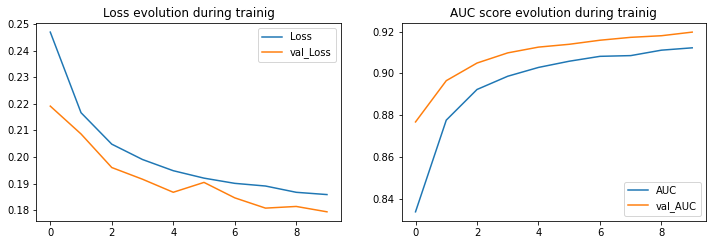

In [13]:
plot_learning_evolution(r)

In [14]:
# y_pred = model.predict(test_dataset)
# confusion_matrix(y_test, y_pred.round())

# Saving and Uploading the model

In [15]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [16]:
tf.keras.models.save_model(model, "hate_speech_10_epochs.hdf5")
model.save("hate_speech_10_epochs.h5")

In [17]:
hdf5_model = tf.keras.models.load_model("hate_speech_10_epochs.hdf5")
hdf5_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [18]:
h5_model = tf.keras.models.load_model("hate_speech_10_epochs.h5")
h5_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [19]:
def prep_sentence(sentence):
    tokens = tokenizer.encode_plus(
        sentence, max_length=SEQ_LEN,
        truncation=True, padding='max_length',
        add_special_tokens=True, return_token_type_ids=False,
        return_attention_mask=True, return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(tokens['input_ids'], tf.float64),
        'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)
    }

# Toxic Comments

In [20]:
toxic_speechs = [
    'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK',
    'MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MOVIES. HE HAS SO MUCH BUTTSEX THAT HIS ASSHOLE IS NOW BIG ENOUGH TO BE CONSIDERED A COUNTRY.',
    "A block ohhhhhhhhhhhhhh noooooooooooo I'm soooo like gonna cry and like shit ... ha ha.  you think i care?  i dont even use wikipedia.  look at the serb reporting me to the geek squad, what are you like 5?  Rumor has it that you are another canadian serb.  Rumor has it that you have pissed of a select few from B93 & WP.   )  BYE BYE.",
    "it is a constructive edit you idiot, every kid of every age should know that santa claus is fucking fictional. ever since i first heard of santa claus i knew that he was fictional, my parents didn't give me any delusions and if they had, i would've laughed in their faces and said it isn't logical because it fucking isn't. every kid should be logical just like i was and every kid should be able to logically fucking infer that there is no fucking santa claus in the real human universe.",
    'honestly ==\nyou need to crawl under a rock and DIE YOU FAT BASTARD\n\n=='
]

In [21]:
for speech in toxic_speechs:
    prediction = h5_model.predict(prep_sentence(speech))
    print(prediction)

[[0.5430674]]
[[0.38300273]]
[[0.40779674]]
[[0.63300586]]
[[0.5390873]]


In [22]:
for speech in toxic_speechs:
    prediction = hdf5_model.predict(prep_sentence(speech))
    print(prediction)

[[0.5430674]]
[[0.38300273]]
[[0.40779674]]
[[0.63300586]]
[[0.5390873]]


# Non-Toxic Comments

In [23]:
non_toxic_speechs = [
    "Gale, you're living proof why wikipedia should NEVER be trusted as fact. I mean, telling someone to blindly believe whatever's said instead of verifying? You need to take a walk in traffic for saying that!\n\n99.149.119.168",
    'EastEnders Manual of Style \n\nHello, just wanted you to be aware of the EE MoS, which helps us work out what is appropriate for Infoboxes etc.  Cheers,  (Talk)',
    'You need to provide high-quality secondary sources (e.g., not original publications from medical experiments, but perhaps review articles or medical textbooks) that support this significant change in definition.',
    "I appreciate your responses, guys. I take the recommendation as an admin as a great compliment. However, since I move around so much and my knowledge of Wikipedia isn't where I would like it to be before I went after something like that, I will get back to you if the vote ever happens. In the mean time, I definitely appreciate the compliment. }",    
    "Stop reinserting harrassing content on WP:ANI \n\nStop readding this material.  If you continue with this from other IP ranges or addresses we will be forced to block larger IP ranges from editing.  You aren't allowed to harrass people like this on Wikipedia."
]

In [24]:
for speech in non_toxic_speechs:
    prediction = h5_model.predict(prep_sentence(speech))
    print(prediction)

[[0.17475249]]
[[0.01649178]]
[[0.00066787]]
[[0.013166]]
[[0.05405284]]


In [25]:
for speech in non_toxic_speechs:
    prediction = hdf5_model.predict(prep_sentence(speech))
    print(prediction)

[[0.17475249]]
[[0.01649178]]
[[0.00066787]]
[[0.013166]]
[[0.05405284]]
